# Kpop Success Analysis

##### "Which factors matter most for K-pop success, and for fun, how well can I predict success with my own knowledge?"


## Fixing dataset to exclude astrology

In [44]:
import pandas as pd

raw_df = pd.read_csv("kpop_group_debut_astrology.csv")
keep_columns = ["group_name", "company", "status", "group_type", "paks", "music_show_awards", "end_year_awards", "physical_sales",
                "organic_youtube_views", "debut_date"]
df = raw_df[keep_columns]
df.to_csv("kpop_data.csv", index=False)

## Adding subjective "knowledge score" column:
##### To be used for unique interpretations

In [45]:
df = df.copy()

# 2 = I know the group & I know they are/were popular
# 1 = I know the group & don't think they are/were popular
# 0 = I don't know the group
knowledge = [2,2,2,0,2,2,2,1,2,2,1,2,0,0,0,2,2,2,1,0,0,0,2,2,1,1,0,0,
             2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,0,0,2,2,2,2,2,2,2,2,2,2,2,
             2,2,2,1,2,2,1,2,2,1,1,2,1,2,1,2,1,0,2,2,2,0,1,1,0,0,0,1,
             1,1,2,1,0,1,1,0,1,1,1,1,1,1,1,0,0,2,2,0,0,0,0,1,1,2,0,0,
             1,0,2,0,1,0,0,0]

df["self_knowledge_score"] = knowledge

## Prepping groups based off company, debut date, youtube views, etc.

In [46]:
df = df.copy()

# First, I wanted to work with organic youtube views
df[df["organic_youtube_views"] <= 160000000][["group_name", "organic_youtube_views"]]

# At first, this seemed to work, any group under 100,000,000 organic youtube views seems to not be as popular.
# However, from my knowledge, H.O.T was an insanely popular group back when kpop first started. That's when I
# realized that debut date would matter for youtube views, since youtube is an overall larger platform right now
# than it was back in the late 1900s.
df[df["organic_youtube_views"] <= 100000000][["group_name", "organic_youtube_views", "debut_date"]]
df["debut_date"] = pd.to_datetime(df["debut_date"], errors="coerce")
df["debut_year"] = df["debut_date"].dt.year

# Converting companies to tiers
Big_Four = ["YG Entertainment Inc.", "JYP Entertainment Corp.", "SM Entertainment Co. Ltd.", "Big Hit Music"]

Mid_Tier = ["Starship Entertainment", "Cube Entertainment", "FNC Entertainment", "Pledis Entertainment", "ADOR", 
            "The Black Label", "WAKEONE Entertainment", "BELift Lab (HYBE + CJ E&M)", "Source Music"]

def company_tier(group):
    if group in Big_Four:
        return 3
    elif group in Mid_Tier:
        return 2
    else:
        return 1
    
df["company_tier"] = df["company"].apply(company_tier)

# Grouping by group gender
df["group_type_encoded"] = df["group_type"].map({"Boy Group": 0, "Girl Group": 1, "Co-ed Group": 2})

# Groupings by debut date/generation
def get_generation(year):
    if year <= 2003:
        return 1
    elif 2003 < year < 2012:
        return 2
    elif 2012 <= year < 2018:
        return 3
    elif 2018 <= year < 2023:
        return 4
    elif 2023 <= year <= 2025:
        return 5
    else:
        return None

df["generation"] = df["debut_year"].apply(get_generation)

## Creating Success Model 


In [47]:
df["success_score"] = (df["organic_youtube_views"] / 1000000 + df["physical_sales"] / 10000 + df["music_show_awards"])

df["success_binary"] = (df["success_score"] >= 1500).astype(int)

# Tried all combinations with company tiers, group types, and generations, and this combination somehow has the best output
features = ["company_tier", "group_type_encoded"]

X = df[features]
y = df["success_binary"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Testing with model

In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

rf_results = {}

for n in [50, 100, 200, 300, 400]:
    model = RandomForestClassifier(n_estimators = n, random_state = 42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    rf_results[f"n = {n}"] = accuracy

svm_results = {}

for C in [0.1, 1, 5, 10]:
    model = SVC(kernel = "rbf", C = C)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    svm_results[f"C = {C}"] = accuracy

other_models = {
    "Logistic_Regression": LogisticRegression(max_iter = 200),
    "SVC_linear": SVC(kernel = "linear", C = 1),
    "GradientBoosting": GradientBoostingClassifier()
    }

results = {}

for name, model in other_models.items():
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    results[name] = accuracy

print(rf_results)
print(svm_results)
print(results)

{'n = 50': 0.7916666666666666, 'n = 100': 0.7916666666666666, 'n = 200': 0.7916666666666666, 'n = 300': 0.7916666666666666, 'n = 400': 0.7916666666666666}
{'C = 0.1': 0.7083333333333334, 'C = 1': 0.75, 'C = 5': 0.75, 'C = 10': 0.75}
{'Logistic_Regression': 0.75, 'SVC_linear': 0.7083333333333334, 'GradientBoosting': 0.7916666666666666}


## Generation Analysis: 1st to 5th

In [49]:
first_gen = df[df["generation"] == 1]
second_gen = df[df["generation"] == 2]
third_gen = df[df["generation"] == 3]
fourth_gen = df[df["generation"] == 4]
fifth_gen = df[df["generation"] == 5]

# Computing average success by company tier
for i, gen in enumerate([first_gen, second_gen, third_gen, fourth_gen, fifth_gen], start=1):
    print(f"\nGeneration {i}:")
    print(gen.groupby("company_tier")["success_score"].mean())
# Results show scores for each company for each generation
# For example, Generation 1 doesn't have too big of a difference between scores from tier 1 companies and tier 3 companies.
# However, in the third generation, tier 3 companies have a success score 10 times larger than tier 1 companies.

# Computing how many successful groups came from each company tier throughout the generations
for i, gen in enumerate([first_gen, second_gen, third_gen, fourth_gen, fifth_gen], start=1):
    print(f"\nGeneration {i} successful group counts:")
    print(gen.groupby("company_tier")["success_binary"].sum())
# These results basically just show how many successful groups each company tier had. 
# For example, from generations 2 to 4, a minimum of 70% to even 100% of successful groups each generation were from 
# high prestige companies.

# Basically computes a numerical measure of how strongly companies mattered in each generation
for i, gen in enumerate([first_gen, second_gen, third_gen, fourth_gen, fifth_gen], start=1):
    corr = gen["company_tier"].corr(gen["success_score"])
    print(f"Generation {i} correlation (company tier vs success): {corr}")
# Results show a percentage correlation of how much company tier correlates with success, with generation 4,
# for example, showing a correlation of 66.33%.


Generation 1:
company_tier
1    258.489588
3    514.525501
Name: success_score, dtype: float64

Generation 2:
company_tier
1     571.918448
2     624.551674
3    1945.033892
Name: success_score, dtype: float64

Generation 3:
company_tier
1     885.858352
2    1687.115730
3    9678.367068
Name: success_score, dtype: float64

Generation 4:
company_tier
1     663.417652
2    2261.986527
3    4016.963610
Name: success_score, dtype: float64

Generation 5:
company_tier
1    281.940350
2    338.440334
3    687.121549
Name: success_score, dtype: float64

Generation 1 successful group counts:
company_tier
1    0
3    0
Name: success_binary, dtype: int64

Generation 2 successful group counts:
company_tier
1    0
2    0
3    5
Name: success_binary, dtype: int64

Generation 3 successful group counts:
company_tier
1    4
2    2
3    7
Name: success_binary, dtype: int64

Generation 4 successful group counts:
company_tier
1    1
2    5
3    5
Name: success_binary, dtype: int64

Generation 5 successf

## Testing my knowledge of kpop against the model I trained

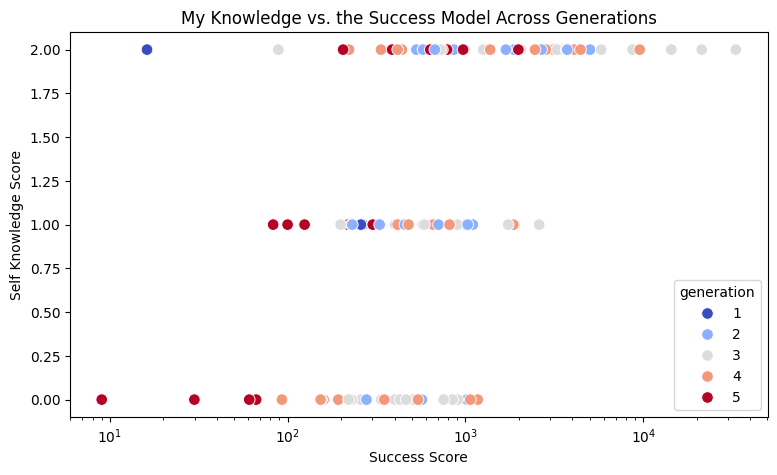

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
sns.scatterplot(x=df["success_score"], y=df["self_knowledge_score"], hue=df["generation"], palette="coolwarm", s=70)
plt.xscale("log")
plt.xlabel("Success Score")
plt.ylabel("Self Knowledge Score")
plt.title("My Knowledge vs. the Success Model Across Generations")
plt.show()

# For the graph, the y-axis is my knowledge. From top to bottom, it's how well I know the group and if I said they're popular or not. For example,
# if a dot is in the upper left corner of the plot, it means that I thought it was a well-known, successful group, but the model says it's not.
# Another example, for dots in the center top area, it means I thought those were successful and popular groups, but the model says they're 
# average at best.

## How much does my knowledge match with the success model?

In [51]:
corr = df["success_score"].corr(df["self_knowledge_score"])
print("Correlation:", corr)
print("Percent alignment:", round(corr * 100, 2), "%")

Correlation: 0.30809412091833854
Percent alignment: 30.81 %


## Which groups did I correctly identify?

In [52]:
knowledgeable = df[df["self_knowledge_score"] == 2]
percent_correct = knowledgeable["success_binary"].mean() * 100
print(f"Out of all the groups, the percent of groups I correctly identified as successful was {percent_correct:.2f}%")

# I guess I'm not as knowledgable in kpop as I thought, either that or my model's a bit off. Either way, my knowledge of kpop was
# not even 50% correct for this dataset.

Out of all the groups, the percent of groups I correctly identified as successful was 46.43%


## Were any of my guesses regarding successfulness wrong?

In [53]:
successful = df[df["success_binary"] == 1]
missed = successful[successful["self_knowledge_score"] == 0]

percent_missed = (len(missed) / len(successful)) * 100
percent_correct = 100 - percent_missed

print(f"Among the groups I rated as ‘2’ (high familiarity), I was {percent_correct:.2f}% correct.")

# So, this means I'm familiar enough with kpop to be able to identify the super popular groups at the least.

Among the groups I rated as ‘2’ (high familiarity), I was 100.00% correct.


## Visualizations

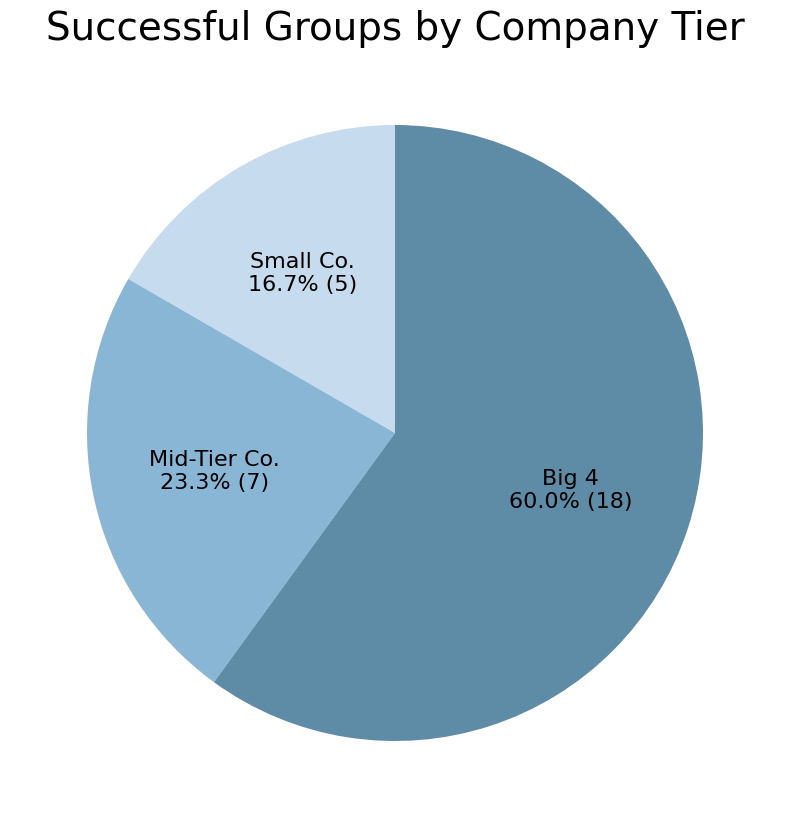

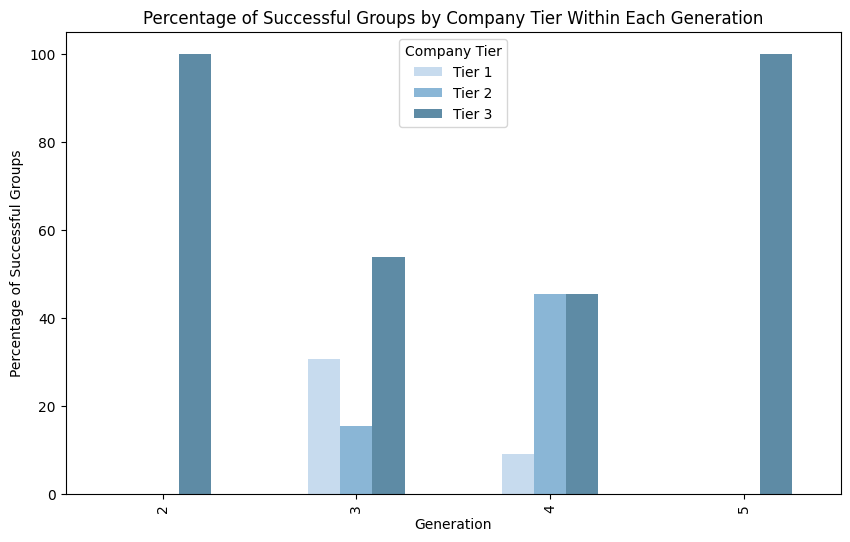

In [67]:
import matplotlib.pyplot as plt

# Pie chart to visualize how many successful groups come from prestigious vs. unknown companies
success_counts = df[df["success_binary"] == 1]["company_tier"].value_counts().sort_index()

tier_labels_map = {
    1: "Small Co.",
    2: "Mid-Tier Co.",
    3: "Big 4"
}
labels = [tier_labels_map[tier] for tier in success_counts.index]

def label_inside(percent, label):
    total = sum(success_counts)
    count = int(round(percent * total / 100))
    return f"{label}\n{percent:.1f}% ({count})"

labels = [tier_labels_map[tier] for tier in success_counts.index]

plt.figure(figsize=(10, 10))
plt.pie(
    success_counts,
    labels=None,
    autopct=lambda pct: label_inside(pct, labels.pop(0)),
    startangle=90,
    textprops = {'fontsize': 16},
    colors = ["#c7dbee", "#8ab6d6", "#5e8ba5"]
)
plt.title("Successful Groups by Company Tier", fontsize=28)
plt.show()


# Bar chart to show how many successful groups each company tier produced each generation
success = df[df["success_binary"] == 1]
counts = success.groupby(["generation", "company_tier"]).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages.columns = ["Tier 1", "Tier 2", "Tier 3"]

percentages.plot(kind="bar", figsize=(10,6), color=["#c7dbee", "#8ab6d6", "#5e8ba5"])
plt.title("Percentage of Successful Groups by Company Tier Within Each Generation")
plt.xlabel("Generation")
plt.ylabel("Percentage of Successful Groups")
plt.legend(title="Company Tier")
plt.show()
